In [2]:
from camera_calibrator import *
from lane_lines import *
import os
import sys
import imghdr
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [3]:
def show_grid(images, n_rows, n_cols):
    plt.figure(figsize=[16, 5])
    for i in range(len(images)):
        img = images[i]
        plt.subplot(n_rows, n_cols, i+1)
        if len(img.shape) == 3:
            plt.imshow(img)
        else:
            plt.imshow(img, cmap='gray')

processing broken1.jpg...
processing broken2.jpg...


processing harder1.jpg...


processing straight_lines1.jpg...
processing straight_lines2.jpg...


processing test1.jpg...
processing test2.jpg...


processing test3.jpg...
processing test4.jpg...


processing test5.jpg...
processing test6.jpg...


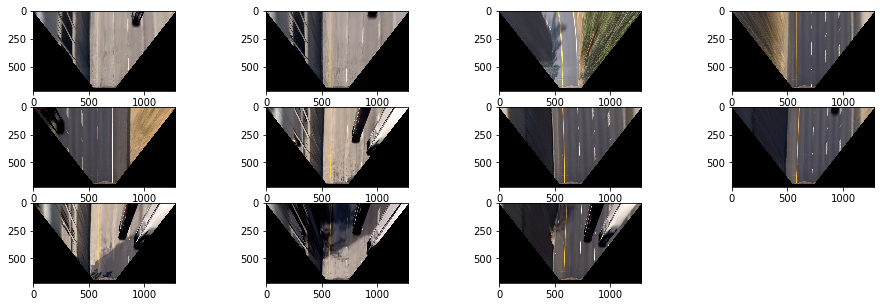

In [4]:
images = []

cameraMatrix, distCoeffs, newCameraMatrix, validPixROI = load_camera_calibration("camera_cal.npz")

for file in os.scandir("test_images"):
    if not file.name.startswith('.') and file.is_file():
        print("processing {0}...".format(file.name))

        # read in the image
        image = mpimg.imread(file.path)
        
        # undistort image
        dst = undistort_image(image, cameraMatrix, distCoeffs)

        # transform perspective to bird's eye view
        to_birdseye, to_forward = get_birdseye_transforms()
        bey = cv2.warpPerspective(dst, to_birdseye, (dst.shape[1], dst.shape[0]), flags=cv2.INTER_LINEAR)

        images.append(bey)

show_grid(images, 3, 4)

In [5]:
def my_gradient_threshold_lanes(img, abs_kernel=3, mag_kernel=3, dir_kernel=3,
                                abs_thresh=(0, 255), mag_thresh=(0, 255), dir_thresh=(0, np.pi/2),
                                use_absx=True, use_absy=True, use_mag=True, use_dir=True,
                                erode=True, erode_ksize=4, tophat=True, tophat_ksize=10, chop=True):
    """
    takes in an RGB image and applies Sobel operator to find magnitude and direction of gradient
    :param img: 
    :param abs_kernel: 
    :param mag_kernel: 
    :param dir_kernel: 
    :param abs_thresh: 
    :param mag_thresh: 
    :param dir_thresh: 
    :param use_absx: 
    :param use_absy: 
    :param use_mag: 
    :param use_dir: 
    :param erode: 
    :param erode_ksize: 
    :param tophat: 
    :param tophat_ksize: 
    :param chop: 
    :return sobel_output: 
    """

    # create structuring elements
    se_tophat_ellipse = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(tophat_ksize, tophat_ksize*2))
    se_erode_rect = cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE, ksize=(erode_ksize, erode_ksize))

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # erode away noise
    if erode:
        gray = cv2.erode(gray, se_erode_rect)
    # tophat away large objects
    if tophat:
        gray = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, se_tophat_ellipse)

    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=abs_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=abs_kernel)

    # Calculate the absolute gradient values
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # Rescale to 8 bit
    scaled_sobelx = np.uint8(255 * abs_sobelx / np.max(abs_sobelx) )
    scaled_sobely = np.uint8(255 * abs_sobely / np.max(abs_sobely))
    # Create a binary image of ones where threshold is met, zeros otherwise
    gradx = np.ones_like(scaled_sobelx)
    grady = np.ones_like(scaled_sobely)
    if use_absx:
        gradx[(scaled_sobelx < abs_thresh[0]) | (scaled_sobelx > abs_thresh[1])] = 0
    if use_absy:
        grady[(scaled_sobely < abs_thresh[0]) | (scaled_sobely > abs_thresh[1])] = 0

    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=mag_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=mag_kernel)

    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_output = np.ones_like(gradmag)
    if use_mag:
        mag_output[(gradmag < mag_thresh[0]) | (gradmag > mag_thresh[1])] = 0

    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=dir_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=dir_kernel)

    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # Create a binary image of ones where threshold is met, zeros otherwise
    dir_output = np.ones_like(absgraddir)
    if use_dir:
        dir_output[(absgraddir < dir_thresh[0]) | (absgraddir > dir_thresh[1])] = 0

    # combine all Sobel gradients into one big gradient lovefest
    # peg binary image as white or black for ease of display
    sobel_output = np.zeros_like(img[:, :, 0])
    if not use_absx and not use_absy and not use_mag and not use_dir:
        sobel_output = gray
    elif not use_absx and not use_absy:
        sobel_output[((mag_output == 1) & (dir_output == 1))] = 255
    elif not use_mag and not use_dir:
        sobel_output[((gradx == 1) & (grady == 1))] = 255
    else:
        sobel_output[((gradx == 1) & (grady == 1)) | ((mag_output == 1) & (dir_output == 1))] = 255

    # chop off sides
    if chop:
        sobel_output[:, 0:520] = 0
        sobel_output[:, 760:1280] = 0

    return sobel_output

In [6]:
from IPython.html.widgets import *

def interactive_sobel(abs_kernel=3, mag_kernel=9, dir_kernel=15,
                      abs_thr_low=20, abs_thr_high=100,
                      mag_thr_low=30, mag_thr_high=100,
                      dir_thr_low=0.7, dir_thr_high=1.3,
                      use_absx=True, use_absy=True, use_mag=True, use_dir=True,
                      erode=True, erode_ksize=4, tophat=True, tophat_ksize=10, chop=True):
    sobel_images = []
    for image in images:
        sth = my_gradient_threshold_lanes(image, abs_kernel=abs_kernel, mag_kernel=mag_kernel, dir_kernel=dir_kernel,
                                       abs_thresh=(abs_thr_low, abs_thr_high),
                                       mag_thresh=(mag_thr_low, mag_thr_high),
                                       dir_thresh=(dir_thr_low, dir_thr_high),
                                       use_absx=use_absx, use_absy=use_absy, use_mag=use_mag, use_dir=use_dir,
                                       erode=erode, erode_ksize=erode_ksize, tophat=tophat, tophat_ksize=tophat_ksize, chop=chop)
        sobel_images.append(sth)
    show_grid(sobel_images, 3, 4)

In [7]:
interact_manual(interactive_sobel,
                abs_kernel=(1, 15, 2),
                mag_kernel=(1, 15, 2),
                dir_kernel=(1, 15, 2),
                abs_thr_low=(0, 255, 5),
                abs_thr_high=(0, 255, 5),
                mag_thr_low=(0, 255, 5),
                mag_thr_high=(0, 255, 5),
                dir_thr_low=(0, np.pi/2, 0.1),
                dir_thr_high=(0, np.pi/2, 0.1),
                use_absx=True, use_absy=True, use_mag=True, use_dir=True,
                erode=True, erode_ksize=(0, 20, 1), tophat=True, tophat_ksize=(0,100), chop=True)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


<function __main__.interactive_sobel>